# Chapter05 リカレントニューラルネットワーク(RNN)

---

### 前準備

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from common.layers import *
from common.optimizer import SGD
from dataset import ptb

---

## 確率と言語モデル

- 言語モデル: 単語の並びに対し, それがどれだけ起こりうるかを確率で評価する
  - 音声認識等のアプリケーションで使用可能
  - 確率分布に従い新しい文章生成の用途にも利用可能

#### 言語モデルを数式で記述
- $P(w_1,...,w_m)$: $w_1,...,w_m$までのm個の単語において, $w_1,...,w_m$という順序で単語が出現する確率
  - これを事後確率を使用すると以下のように分解できる
$$
P(w_1,...,w_m) = P(w_m|w_1,...,w_{m-1})P(w_{m-1}|w_1,...w_{m-2})...P(w_3|w_1,w_2)P(w_2|w_1)P(w_1) = \Pi_{t=1}^mP(w_t|w_1,...w_{t-1})
$$

- 言語モデルが扱う事後確率: t番目の単語を他ゲットとして, t番目より左側の単語全てをコンテキストとする
  - ちなみに$P(w_t|w_1,...,w_{t-1})$を表すモデルを条件付き言語モデルと呼ぶ, またこのモデルを言語モデルと呼ぶ場合もある

#### CBOWモデルを言語モデルへ適用 
- コンテキストサイズをある値に固定することで近似的に表現するという方法(下の例はコンテキストサイズを2とした場合)
  - $P(w_1,...,w_m)=\Pi_{t=1}^mP(w_t|w_1,...w_{t-1}) \approx \Pi_{t=1}^mP(w_t|w_{t-2},w_{t-1})$
  - この方法はコンテキストサイズを任意の長さに固定できる
  - 一方でそのサイズより左側にある単語情報を無視するため, 指定したサイズよりも前に出現する単語の情報が必要となる文では正答が難しくなる
    - CBOWモデルではコンテキスト内の単語の並びが無視される((you, say)と(say, you)は同じコンテキストとして扱われる)為, サイズを大きくしても解決できない
    - そこでRNNの出番
    
---

## RNN(Recurent Neural Network)

- 再帰NN, 循環NNなどと訳される
- Recursive Neural Networkの1種である, これはリカレントニューラルネットワークとは別物
- RNNは閉じた経路(ループする経路)を持っており, この経路によって過去の情報を記憶しつつ最新データへと更新される
- 各時刻のRNNレイヤは, そのレイヤへの入力と一つ前のRNNレイヤからの出力を受け取り, その2つの情報を基にその時刻の出力が計算される
  - これを計算式で表すと以下のようになる

$$
h_t = \tanh(h_{t-1}W_h+x_tW_x+b)
$$

- $x$: 入力($x_t$は行ベクトル)
- $h$: 出力($h_{t-1}$は行ベクトル)
- $t$: 時刻
- $W_x$: 入力$x$を出力$h$に変換するための重み
- $W_h$: 一つ前のRNNの出力を次時刻の出力に変換するための重み
- $b$: バイアス
- $\tanh$: 双曲線正接関数

---

### BPTT(Backpropagation Through Time)

- RNNは通常の誤差逆伝播法を使用できる(i.e. 順伝播→逆伝播を行うことで目的の勾配を求められる)
  - この誤差逆伝播法は,「時間方向に展開したNNの誤差逆伝播法」ということでBPTTと呼ばれる
- デメリット
  - 時系列データの時間サイズの大きさに比例してBPTTで消費するコンピュータの計算リソースも増加する
  - 時間サイズの増加に伴い, 逆伝播時の勾配が不安定になる
  
- 上記デメリットの対策手法がTruncated BPTT
  - 時間軸方向に長いネットワークのつながりを適当な場所で切り取り小さいネットワークを複数つくり, それらに誤差逆伝播法を行う
    - 正確に言うと切り取るのはネットワークの逆伝播のつながりのみで, 順伝播のつながりは維持する
    - 維持のためにはデータをシーケンシャルに与える, ミニバッチの各バッチでデータを与える開始位置をズラして読み込む必要がある

---

### RNNレイヤ, Time RNNレイヤの実装

- 本書では時系列データをまとめて処理するレイヤにはTimeを頭につけるという命名規則が定義されている
  - なのでTステップ分の処理をまとめて行うレイヤをTime RNNレイヤ, Time RNNレイヤ内の1ステップの処理を行うレイヤをRNNレイヤとしている
    - RNN $\in$ Time RNNみたいなイメージ

In [21]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

In [22]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        '''
        stateful=Trueであれば状態を持つ事になる → 長い時系列データであっても順伝播を断ち切ること無く伝播させる
        stateful=Falseであればforward()が呼ばれる度, 最初のRNNレイヤの隠れ状態をゼロ行列で初期化する
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
    
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :]+dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                self.grads[i][...] = grad
            self.dh = dh
            
        return dxs

---

## 時系列データを扱うレイヤの実装

- この章での目標はRNNを使って言語モデルを実装すること
  - 以降RNNによる言語モデルはRNNLM(RNN Language Model)とする

- $t$個ある入出力$w, y$の内, $w_i$の出力を$y_i$とするとネットワーク全体では以下の処理を$t$回行っている
  - 1.Embedding
  - 2.RNN
  - 3.Affine
  - 4.Softmax(Softmax with Loss)

- 各レイヤにおける$t$回の処理をそれぞれのTimeレイヤでまとめる
  - 1.Time Embedding
  - 2.Time RNN (実装済み)
  - 3.Time Affine
  - 4.Time Softmax(Softmax with Loss)

    - このうち未実装の3つのレイヤを実装する

In [23]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    # T個のSoftmax with Lossレイヤで算出されたそれぞれの損失を, 合算し平均を取ったものを最終的損失とする
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

---

## RNNLMの学習と評価

In [24]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

---

### 言語モデルの評価

- 言語モデルでは過去に与えられた単語から次に出現する単語の確率分布を出力する
  - この際の予測性能の良さを評価する指標: パープレキシティ(簡単に言うと確率の逆数)
  - パープレキシティは小さいほど良く(最小値は1.0), この値は分岐数を示す
  - 入力データが複数の場合のパープレキシティ: $perplexity = e^L$($L$はニューラルネットワークの損失)
  
#### RNNLMの学習

- PTBデータセットを利用して学習を行う
  - ただし、本章でのRNNLMは全ての訓練データを対象にすると良い結果を出せない為, PTBデータセットの先頭の1000単語だけを利用する
  - 次章で改良 

In [29]:
# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 5 # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み(データセットを小さくする)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size= 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 入力
ts = corpus[1:] # 出力(今日調べる)
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み始点を計算
# 各バッチでデータを与える開始位置をズラして読み込む必要があるため
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチ取得
        # データをシーケンシャルに与える
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        # 勾配を求め, パラメータ更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    # epoch毎にパープレキシティの取得
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perp;exity %.2f' %(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

corpus size: 1000, vocabulary size: 418
| epoch 1 | perp;exity 413.44
| epoch 2 | perp;exity 370.55
| epoch 3 | perp;exity 270.09
| epoch 4 | perp;exity 231.00
| epoch 5 | perp;exity 213.25
| epoch 6 | perp;exity 207.25
| epoch 7 | perp;exity 200.72
| epoch 8 | perp;exity 197.06
| epoch 9 | perp;exity 191.71
| epoch 10 | perp;exity 191.53
| epoch 11 | perp;exity 188.42
| epoch 12 | perp;exity 190.10
| epoch 13 | perp;exity 187.67
| epoch 14 | perp;exity 188.12
| epoch 15 | perp;exity 187.40
| epoch 16 | perp;exity 183.26
| epoch 17 | perp;exity 180.95
| epoch 18 | perp;exity 177.95
| epoch 19 | perp;exity 178.93
| epoch 20 | perp;exity 180.68
| epoch 21 | perp;exity 178.13
| epoch 22 | perp;exity 174.46
| epoch 23 | perp;exity 171.31
| epoch 24 | perp;exity 173.15
| epoch 25 | perp;exity 171.10
| epoch 26 | perp;exity 171.62
| epoch 27 | perp;exity 166.09
| epoch 28 | perp;exity 164.94
| epoch 29 | perp;exity 163.73
| epoch 30 | perp;exity 158.76
| epoch 31 | perp;exity 159.88
| epoch 

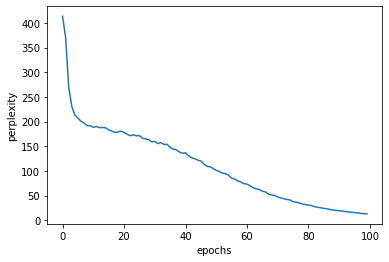

In [30]:
# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()